In [37]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [38]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the linear transformation $X W + b$ and then the softmax function to obtain the class probabilities predicted by the model.

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 定义三个卷积层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=2)   # 输入通道1，输出通道4
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, stride=2, padding=2)  # 输入通道4，输出通道8
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=4, stride=2, padding=1) # 输入通道8，输出通道12

        # 定义全连接层（原第四、五层）
        self.fc1 = nn.Linear(12 * 7 * 7, 200)  # 输入588维（12*7*7），输出200
        self.fc2 = nn.Linear(200, 10)           # 输出10维

    def forward(self, X):
        # 输入形状：(batch_size, 1, 28, 28)，不展平！
        # 卷积层 + ReLU激活
        H1 = F.relu(self.conv1(X))       # 输出形状：(batch_size, 4, 28, 28)
        H2 = F.relu(self.conv2(H1))      # 输出形状：(batch_size, 8, 14, 14)
        H3 = F.relu(self.conv3(H2))      # 输出形状：(batch_size, 12, 7, 7)

        # 展平操作：将三维张量转换为一维向量
        H3_flat = H3.view(-1, 12 * 7 * 7)  # 展平后形状：(batch_size, 588)

        # 全连接层
        H4 = F.relu(self.fc1(H3_flat))    # 输出形状：(batch_size, 200)
        Z = self.fc2(H4)                  # 输出形状：(batch_size, 10)
        return Z

## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [40]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y]

    return -(Y_onehot * G.log()).sum(dim = 1).mean()

The next lines evaluate the accuracy of the predictions.

In [41]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [42]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 5000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy  14.00% train cross-entropy  2.30  test accuracy  25.68% test cross-entropy   nan
Step   100: train accuracy  86.00% train cross-entropy  0.41  test accuracy  89.63% test cross-entropy   nan
Step   200: train accuracy  93.00% train cross-entropy  0.31  test accuracy  93.19% test cross-entropy   nan
Step   300: train accuracy  96.00% train cross-entropy  0.18  test accuracy  95.04% test cross-entropy   nan
Step   400: train accuracy  95.00% train cross-entropy  0.12  test accuracy  95.48% test cross-entropy   nan
Step   500: train accuracy  96.00% train cross-entropy  0.13  test accuracy  95.48% test cross-entropy   nan
Step   600: train accuracy  98.00% train cross-entropy  0.09  test accuracy  95.93% test cross-entropy   nan
Step   700: train accuracy  97.00% train cross-entropy  0.11  test accuracy  96.26% test cross-entropy   nan
Step   800: train accuracy  98.00% train cross-entropy  0.06  test accuracy  96.84% test cross-entropy   nan
Step   900: train a

## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

ValueError: Axis limits cannot be NaN or Inf

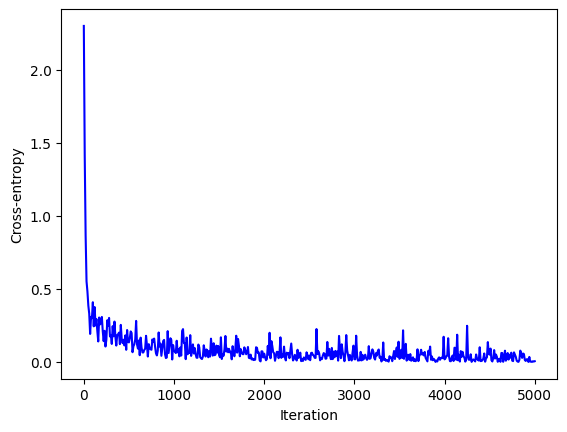

In [43]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

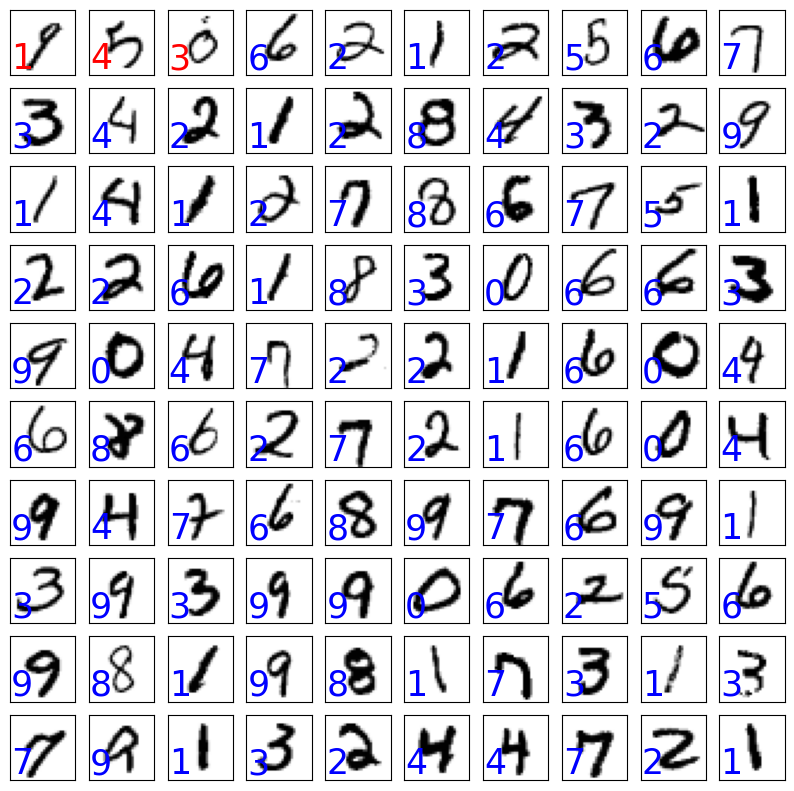

In [36]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()